# Load packages

In [10]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt
import matplotlib as mpl
import math

## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from sklearn.impute import SimpleImputer
#from scipy.stats import shapiro  #check normalicy of seasonal trend distribution
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der, least_squares
from sklearn.preprocessing import StandardScaler
import pickle

##import functions for fitting
from symfit import parameters, variables, Fit
from symfit import pi,sqrt,log,exp,sinh
from symfit import sin, cos


# statistics which aren't all that nice in python
import rpy2.robjects as robjects

# ## my stuff
# sys.path.insert(1,'/home/tristan/mesmer/tools')
# #from tools.loading import load_data_single_mod
# from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
# from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed


In [2]:
import sklearn
print(sklearn.__version__)


0.20.1


# Define functions

In [3]:
##define function to do fitting on
def season_mimic(x, mon, n=2):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a = parameters(','.join(['a{}'.format(i) for i in range(1, n + 1)]))
    b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    c = parameters(','.join(['c{}'.format(i) for i in range(1, n + 1)]))
    d = parameters(','.join(['d{}'.format(i) for i in range(1, n + 1)]))
   
    # Construct the series
    series =    sum((ai*x + bi)*sin(pi*i*(mon%12+1)/6)+(ci*x+di)*cos(pi*i*(mon%12+1)/6)for i,(ai, bi, ci, di) in enumerate(zip(a, b,c,d)))
    return series

In [4]:
def fit_to_bic(x_train,mon_train,y_all_mon,max_period=10):
    
    #create mask to mask out NaN values
    mask_nan=~np.isnan(x_train)    
    y_all_mon=y_all_mon.reshape(tot_months,-1)[mask_nan,:]
    x_train=x_train[mask_nan]
    mon_train=mon_train[mask_nan]
    
    n=len(x_train)
    bic=np.zeros(max_period)
    for i in range (1,max_period+1):
        
        num_params=2+(4*i)
        x, mon, z = variables('x, mon, z')
        model_dict = {z: season_mimic(x, mon, n=i)}
        
        if i==1:
            fit=Fit(model_dict, x=x_train, z=y_all_mon)
            mse=mean_squared_error(y_all_mon,fit.model(x=x_train, **fit.execute().params).z)
        else:
            fit=Fit(model_dict, x=x_train, mon=mon_train,z=y_all_mon)
            mse=mean_squared_error(y_all_mon,fit.model(x=x_train, mon=mon_train,**fit.execute().params).z)
        
        bic[i-1] = n * log(mse) + num_params * log(n)
        
    order_chosen=np.where(bic==min(bic))[0][0]+1
    
    
    model_dict_chosen = {z: season_mimic(x, mon, n=order_chosen)}
    fit=Fit(model_dict_chosen, x=x_train, mon=mon_train, z=y_all_mon)
    
    return fit.execute()

In [5]:
def fit_fmin(self, X, y):
    """Estimate the optimal parameter lambda for each feature.
    The optimal lambda parameter for minimizing skewness is estimated on
    each feature independently using maximum likelihood.
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The data used to estimate the optimal transformation parameters.
    y : temp values to calculate lmbda as lmbda = a*y + b
    Returns
    -------
    self : object
    """
    
    X = X.copy()  # force copy so that fit does not change X inplace


    self.coeffs_ =[]
    for i_grid in tqdm(np.arange(idx_l.sum())):
#         print(X.shape, y.shape)
        self.coeffs_.append(yeo_johnson_optimize_fmin(self,X[:,i_grid],y[:,i_grid]))
        
        
    self.coeffs_=np.array(self.coeffs_)
    #print(self.coeffs_.shape)
    self.mins_ = np.amin(X, axis=0)
    self.maxs_ = np.amax(X, axis=0)
    #print(self.coeffs_)
    
    if self.standardize:
        self._scaler = StandardScaler(copy=True)
        self._scaler.fit(X)
        
    return self
    
def transform_fmin(self, X, y):
        """Apply the power transform to each feature using the fitted lambdas.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data to be transformed using a power transformation.
        Returns
        -------
        X_trans : array-like, shape (n_samples, n_features)
            The transformed data.
        """

        lambdas=get_yeo_johnson_lambdas(self.coeffs_,y)
        
        X_trans=np.zeros_like(X)
        for i, lmbda in enumerate(lambdas.T):
            for j,j_lmbda in enumerate(lmbda):
                with np.errstate(invalid='ignore'):  # hide NaN warnings
                    X_trans[j, i] = self._yeo_johnson_transform(X[j, i], j_lmbda)

        if self.standardize:
            X_trans = self._scaler.transform(X_trans)

        return X_trans

def inverse_transform_fmin(self, X, y):
        """Apply the inverse power transformation using the fitted lambdas.
        The inverse of the Yeo-Johnson transformation is given by::
            if X >= 0 and lambda_ == 0:
                X = exp(X_trans) - 1
            elif X >= 0 and lambda_ != 0:
                X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
            elif X < 0 and lambda_ != 2:
                X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
            elif X < 0 and lambda_ == 2:
                X = 1 - exp(-X_trans)
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The transformed data.
        Returns
        -------
        X : array-like, shape (n_samples, n_features)
            The original data
        """

        if self.standardize:
            X = self._scaler.inverse_transform(X) 
        
        X_inv = np.zeros_like(X)
        
        lambdas=get_yeo_johnson_lambdas(self.coeffs_,y)
        for i, lmbda in enumerate(lambdas.T):
            for j,j_lmbda in enumerate(lmbda):
                with np.errstate(invalid='ignore'):  # hide NaN warnings
                    X_inv[j, i] = self._yeo_johnson_inverse_transform(X[j, i], j_lmbda)
            X_inv[:,i]=np.where(X_inv[:,i]<self.mins_[i],self.mins_[i],X_inv[:,i])
            X_inv[:,i]=np.where(X_inv[:,i]>self.maxs_[i],self.maxs_[i],X_inv[:,i])

        return X_inv

def yeo_johnson_optimize_fmin(self, x, y):
    """Find and return optimal lambda parameter of the Yeo-Johnson
    transform by MLE, for observed data x.
    Like for Box-Cox, MLE is done via the brent optimizer.
    """

    def _neg_log_likelihood(coeff):
        """Return the negative log likelihood of the observed data x as a
        function of lambda."""
        lambdas=2/(1+coeff[0]*np.exp(y*coeff[1]))
        
        x_trans =np.zeros_like(x)
#         print(x.shape)
        #print(lambdas.shape)
        for i, lmbda in enumerate(lambdas):
            x_trans[i] = self._yeo_johnson_transform(x[i], lmbda)
        
        n_samples = x.shape[0]

        loglike = -n_samples / 2 * np.log(x_trans.var())
        loglike += ((lambdas - 1) * np.sign(x) * np.log1p(np.abs(x))).sum()

        return -loglike

    # the computation of lambda is influenced by NaNs so we need to
    # get rid of them
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    # choosing bracket -2, 2 like for boxcox
    bounds=np.c_[[0,0], [1,0.1]]
    
    return minimize(_neg_log_likelihood, np.array([0.01,0.001]), bounds=bounds, method='SLSQP',jac=rosen_der 
               ).x

def get_yeo_johnson_lambdas(coeffs,y):

    lambdas=np.zeros_like(y)
    i=0
    for a,b in zip(coeffs,y.T):
        
        lambdas[:,i]=2/(1+a[0]*np.exp(b*a[1]))
        i+=1
        
    lambdas=np.where(lambdas<0,0,lambdas)
    lambdas=np.where(lambdas>2,2,lambdas)
    
    return lambdas

In [6]:
from sklearn.preprocessing import PowerTransformer

def power_fit(residue,y,fmin=True):
    
    if fmin:
        power_trans = fit_fmin(PowerTransformer(method='yeo-johnson'),residue.reshape(-1, idx_l.sum()),y)
    else:
        power_trans = PowerTransformer(method='yeo-johnson').fit(residue.reshape(-1, idx_l.sum()))
    
    return power_trans
    
def power_transform(mod, residue,y,fmin=True):
    
    if fmin:
        residue_trans = transform_fmin(mod,residue.reshape(-1, idx_l.sum()),y).reshape(-1,idx_l.sum())
    else:
        residue_trans = mod.transform(residue.reshape(-1, idx_l.sum())).reshape(-1,idx_l.sum())
            
    return residue_trans  

def power_inv_transform(mod, residue,y,fmin=True):
    
    if fmin:
        residue_inv_trans = inverse_transform_fmin(mod,residue.reshape(-1, idx_l.sum()),y).reshape(-1,idx_l.sum())
    else:
        residue_inv_trans = mod.inverse_transform(residue.reshape(-1, idx_l.sum())).reshape(-1,idx_l.sum())
            
    return residue_inv_trans  

def compute_llh_cv(res_tr,res_cv,phi):
    """ Compute sum of log likelihood of a set of residuals based on a covariance matrix derived from a different set (of timeslots) of residuals
    
    Keyword arguments:
        - res_tr: the residual of the training run lacking a specific fold after removing the local mean response (nr ts x nr gp). Nans must be removed before
        - res_cv: the residual of a fold which was removed from the training run
        - phi: matrix to localize the covariance matrix based on a specific localisation radius and distance information (phi = output of fct gaspari_cohen(geo_dist/L))
    
    Output:
        - llh_innov_cv: sum of the log likelihood over the cross validation time slots
    
    """

    ecov_res_tr = np.cov(res_tr,rowvar=False)
    cov_res_tr=phi*ecov_res_tr
    
    mean_0 = np.zeros(phi.shape[0]) # we want the mean of the res to be 0

    llh_innov_cv=np.sum(multivariate_normal.logpdf(res_cv,mean=mean_0, cov=cov_res_tr,allow_singular=True))

    return llh_innov_cv   

def leave_one_out(L_set,nr_folds,residue_trans,idx_fo_tot,phi):
    
    def folds_calc(idx_fo,residue_trans,phi,L):
    
        res_tot_est = residue_trans[~idx_fo] 
        res_tot_fo=residue_trans[idx_fo]

        llh_cv=compute_llh_cv(res_tot_est,res_tot_fo,phi[L])
        
        return llh_cv
    
    idx_L=0
    L = L_set[idx_L]
    
    df_llh_cv={}
    df_llh_cv['llh_max']=-10000
    df_llh_cv['all']={}
    df_llh_cv['sum']={}
    df_llh_cv['L_sel']=L_set[idx_L]
    
    while (L-df_llh_cv['L_sel']<=250) and (df_llh_cv['L_sel']<L_set[-1]): # based on experience I know that once stop selecting larger 
            #loc radii, will not start again -> no point in looping through everything, better to stop once max is 
            #reached (to avoid singular matrices)
        L = L_set[idx_L]
        print('start with L ',L)
        df_llh_cv['all'][L]={}
        df_llh_cv['sum'][L]=0
        for i_fold_par in tqdm(np.arange(len(idx_fo_tot.keys()))):
            df_llh_cv['all'][L][i_fold_par]=folds_calc(idx_fo_tot[i_fold_par],residue_trans,phi,L)
            df_llh_cv['sum'][L] += df_llh_cv['all'][L][i_fold_par]
            
       
        #df_llh_cv['all'][L]=Parallel(n_jobs=10,verbose=10)(delayed(folds_calc)(idx_fo_tot[i],residue_trans,phi,L)for i in np.arange(len(idx_fo_tot.keys())))
        
        #print('rest tot fo shape ',res_tot_fo.shape,'res_tot_est shape ',res_tot_est.shape)
        if df_llh_cv['sum'][L]>df_llh_cv['llh_max']:
            df_llh_cv['L_sel']=L
            df_llh_cv['llh_max']=df_llh_cv['sum'][L]
            print('currently selected L=',df_llh_cv['L_sel'])

        idx_L+=1  
    return df_llh_cv

def lin_func(x, a, b):
    return a * x + b

# Loading data and training the harmonic model

## 1. Load in the land mask and create the land index (idx_l)


In [11]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

In [8]:
##Start training for monthly downscaling

y_all_mon={}
y_all={}

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

print("calculating seasonal trends")
        
# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       

df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(lon=72) #open observation data
        
#create the climatology values array
nr_years = 112
tot_months = 12*nr_years 

y_ma = np.zeros((tot_months,idx_l.sum()))  #create emtpy array with correct shape
for i in range(tot_months):
    y_ma[i] = df_obs.climatology.values[i%12,idx_l]    #fill climatology values in the array

print(y_ma.shape)
#create test data over date range - here, 112 years so 1910 incl. to 2022. 
data_test = np.array([df_obs.temperature.values[720:2064,idx_l]])
data_test = data_test.reshape(12*nr_years,idx_l.sum())
        
#load in monthly temperature values by adding the temp anomolies to the climatology
y_all_mon = np.add(y_ma, data_test)

# now subtract the yearly average climatology so we are left with the monthly anomolies (monthly value minus year average)
y_all_mon = np.subtract(y_all_mon, np.reshape(np.tile(np.mean(df_obs.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum())))
print(y_all_mon.shape)

#calculate annual avergage temperature values - here we only need the shape for now
y_all = np.mean(y_all_mon.reshape(-1,12,idx_l.sum()),axis=1) 

##Get directory to store outputs
dir_out_data_mod = '/home/tristan/mesmer/output/'
        
print('Output folder selected, training starting now, please be patient... \n Go outside, take a long walk, have some food, take a nap, enjoy your life for a few hours...')

if not os.path.exists(dir_out_data_mod):
    os.makedirs(dir_out_data_mod)
    print('created dir:',dir_out_data_mod)
         
##prepare training data
months=np.arange(1,13)
mon_train=np.tile(months,y_all.shape[0])

#final check of shapes
#print (np.repeat(y_all[:,0],12).shape,mon_train.shape and y_all_mon[:,0].shape)

seasonal_model_exec= Parallel(n_jobs=12)(delayed(fit_to_bic)(np.repeat(y_all[:,i],12,axis=0),
                                                                   mon_train, y_all_mon[:,i])
                                               for i in tqdm(np.arange(idx_l.sum())))
                    
joblib.dump(seasonal_model_exec,dir_out_data_mod+'seasonal_trend.pkl')
        
print("finito!")

calculating seasonal trends
(1344, 3043)
(1344, 3043)
Output folder selected, training starting now, please be patient... 
 Go outside, take a long walk, have some food, take a nap, enjoy your life for a few hours...
created dir: /home/tristan/mesmer/output/


NameError: name 'Parallel' is not defined

In [ ]:
from time import time

##Extract test and train results
seasonal_mod={}
order_chosen={}

model="BEST observations"
models=[model]

train_results_all={}
train_residue_all={}
y_all_mon={}
y_all={}

#create the climatology values array
nr_years = 112
tot_months = 12*nr_years 

# seasonal_mod={}
# order_chosen={}

for model in models:

########## THIS SECTION CAN BE COMMNENTED OUT IF RUNNING DIRECTLY AFTER RUNNING THE PREVIOUS CELL ##############    
#Get directory to store outputs
    dir_in_data_mod = '/home/tristan/mesmer_data/data/'

    # prepare the inputs as array
    BEST_data = 'obs_data_25.nc'
    data_mask = 'interim_invariant_lsmask_regrid.nc'       
    
    df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(lon=72) #open observation data
        
    #create the climatology values array
    y_ma = np.zeros((tot_months,idx_l.sum()))  #create emtpy array with correct shape
    for i in range(tot_months):
        y_ma[i] = df_obs.climatology.values[i%12,idx_l]    #fill climatology values in the array

    #create test data over date range - here, 127 years so 1910 incl. to 2022 incl. 
    ## 1344 is the number of months from 1910 until 2022
    data_test = np.nan_to_num(np.array([df_obs.temperature.values[720:2064,idx_l]]))
    data_test = data_test.reshape(tot_months,idx_l.sum())
    
    print(data_test.shape)
        
    #load in monthly temperature values by adding the temp anomolies to the climatology
    y_all_mon[model] = np.add(y_ma, data_test)     
    
    # now subtract the yearly average climatology so we are left with residuals
    y_all_mon[model] = y_all_mon[model] - np.reshape(np.tile(np.mean(df_obs.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum()))   

################## UNTIL HERE #########################             
        
    #calculate annual average temperature values- here we use nanmean to calculate the annual means for each gridpoint but skipping any Nan values
    y_all[model] = np.mean(y_all_mon[model].reshape(-1,12,idx_l.sum()),axis=1)
    print(y_all[model].shape)
    
############ here begins the actual training ##############################
    
#     print ("Getting seasonal trends for", model)
    
    nans = np.isnan(y_all_mon[model]).sum()
    print(nans)
    
#     if nans == 0:
#         print("No Nan values, moving on...")
        
#     else:
#         print("Imputing Nan values...")
#         imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
#         SimpleImputer()
#         y_all[model] = imp_mean.fit_transform(y_all[model])
#         print(y_all[model].shape)
        
#         nans = np.isnan(y_all[model]).sum()
#         print(nans)
    dir_in_data_mod = '/home/tristan/mesmer_data/output/'
    seasonal_mod[model]=joblib.load(dir_in_data_mod+'seasonal_trend.pkl')
    
    if os.path.exists(os.path.join(dir_in_data_mod,'seasonal_training_results.pkl')):
        train_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_training_results.pkl')
        
        train_residue_all[model]=np.subtract(y_all_mon[model], train_results_all[model])
        train_residue_all[model]=train_residue_all[model].reshape(-1,12,idx_l.sum())

    else:
        train_results_all[model]=np.zeros_like(y_all_mon[model] ) 
        months=np.arange(1,13)
        mon_train=np.tile(months,y_all[model].shape[0] )
        
        for i in tqdm(np.arange(idx_l.sum())):
            x_train=np.repeat(y_all[model][:,i],12)
            x, mon, z = variables('x, mon, z')
            train_results_all[model][:,i]=seasonal_mod[model][i].model(x=x_train, mon=np.tile(months,nr_years),**seasonal_mod[model][i].params).z
    
        ##store training results
        joblib.dump(train_results_all[model],dir_in_data_mod+'seasonal_training_results.pkl')  

    ###plot order of harmonics chosen
    order_chosen[model]=np.zeros([idx_l.sum()]) 
    
    for i in np.arange(idx_l.sum()):
        fit_result=seasonal_mod[model][i]
        order_chosen[model][i]=int((len(fit_result.params)+2)/4)-1
      
    
    fig=plt.figure(figsize=(10,20))
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'mathtext.default':'regular'}) 
    plt.rcParams.update({'mathtext.default':'it'}) 
    
    ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))

    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)
    y_ma[idx_l]=order_chosen[model]-1
    
    print(y_ma.shape)
    
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.cm.get_cmap('inferno_r', 7),vmin=0,vmax=7,transform=ccrs.PlateCarree(),rasterized=True)
    ax.set_title('Fourier Series %s'%model,y=1.02,fontsize=14)
    ax.add_feature(cfeature.OCEAN)
    cbar=plt.colorbar(mesh_1,ax=[ax],orientation='horizontal',ticks=(np.arange(8)+0.5),shrink=0.8,pad=0.02,aspect=25)
    cbar.set_label('Order')  
    cbar.ax.set_xticklabels(np.arange(8))
    
    ax.coastlines()

    plt.show()

(1344, 3043)
(112, 3043)
0


In [56]:
# # ## run a Shapiro Wilks test on the training residues to get the p-values for each grid point in each month

from scipy.stats import shapiro
p_vals=np.zeros([12,idx_l.sum()])
for i in range(12):        
    p_vals[i,:] = np.hstack(([shapiro(train_residue_all[model].reshape(nr_years,12,idx_l.sum())[:,i,i_grid])[1] for i_grid in np.arange(idx_l.sum())]))

p_vals.shape

(12, 3043)

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


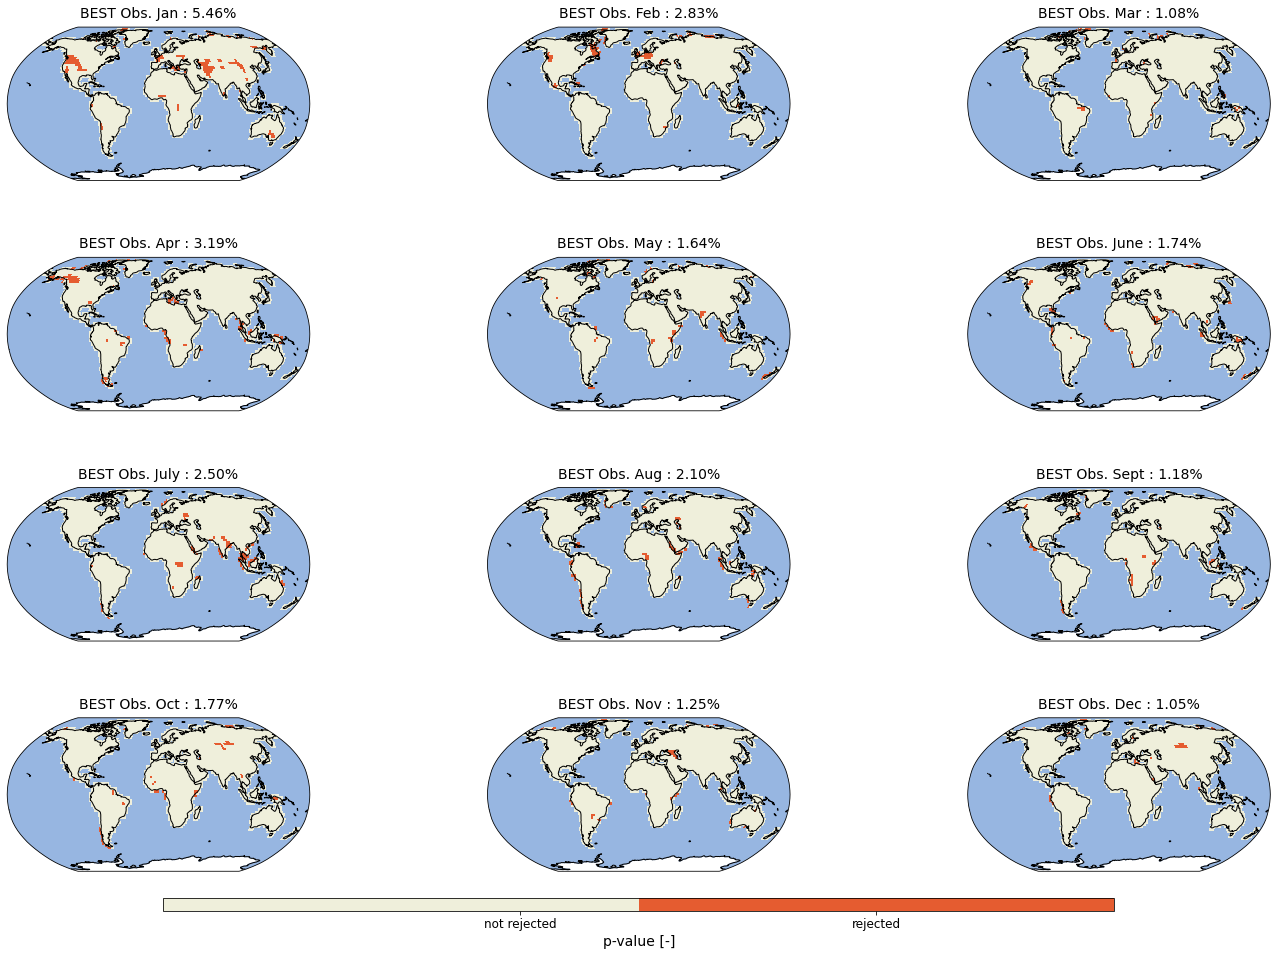

In [41]:
from statsmodels.stats.multitest import multipletests

months=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

white = np.array([248/256, 230/256, 200/256, 1])
blue = np.array([30/256, 70/256, 130/256, 1])
# colors = np.vstack((white,blue))
colors = ['#efefdb', '#e55c30']

mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors, N=2)
bounds = [ -1.5, 0.5, 1.5]
norm = mpl.colors.BoundaryNorm(bounds, mymap.N)
n_col = 3
n_row = 4

fs_title=16

fig=plt.figure(figsize=(n_col*14, n_row * 18))

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.default':'it'})

grid = plt.GridSpec(n_row*12+3, n_col*15+4, wspace=0.25, hspace=0) 

# create a grid for the subplots #0.12

# props = dict(boxstyle='round', facecolor='yellow', alpha=0.5)

for i in range(12):    
    if i%3==0:
        i_y=0
        ax = plt.subplot(grid[i+1:i+3,i_y:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
        
    else:
        ax = plt.subplot(grid[i-(i%3)+1:i-(i%3)+3,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
            
    i_y+=1
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)   
    reject = multipletests(p_vals[i,:],alpha=0.1,method='fdr_bh')[0]
    
    y_ma[idx_l] = reject
    mesh=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,transform=ccrs.PlateCarree(), norm=norm, vmin=0, vmax=0.1, rasterized=True)
    ax.set_title('BEST Obs. %s : %.2f' %(months[i],(reject.sum()/idx_l.sum()*100)) +'%',y=1.02,fontsize=14)
    axcbar = plt.subplot(grid[i-(i%3)+3:i-(i%3)+4,5:25])
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    plt.axis('off')
    

cbar=plt.colorbar(mesh, orientation="horizontal", fraction=0.65,aspect=75, ticks = [0, 1])
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['not rejected','rejected'])
cbar.set_label('p-value [-]',fontsize=14)

plt.tight_layout()


In [24]:
## Transform variables first

power_trans={}
train_residue_trans={}
train_residue_all={}
test_residue_all={}

for model in models:

    print('Training power transformer for,', model)
    train_residue_all[model]=np.subtract(y_all_mon[model], train_results_all[model])
    train_residue_all[model]=train_residue_all[model].reshape(-1,12,idx_l.sum())
    
    
#     x = np.array(train_residue_all[model])
#     print(train_residue_all[model][:,i_mon,:].shape)
    
    power_trans[model]=[]
    for i_mon in tqdm(range(12)):
        power_trans[model].append(power_fit(train_residue_all[model][:,i_mon,:],y_all[model]))

    train_residue_trans[model]=Parallel(n_jobs=12,verbose=10)(delayed(power_transform)(power_trans[model][i_mon],train_residue_all[model][:,i_mon,:],y_all[model]) for i_mon in range(12))
    
    temp_residue_trans=np.zeros_like(train_residue_all[model])
    for i_mon in range(12):
        temp_residue_trans[:,i_mon,:]=train_residue_trans[model][i_mon]
    train_residue_trans[model]=temp_residue_trans
    
    dir_out_data_mod = '/home/tristan/mesmer/output/'
    
    if not os.path.exists(dir_out_data_mod):
        os.makedirs(dir_out_data_mod)
        print('created dir:',dir_out_data_mod)
    joblib.dump(train_residue_trans[model],dir_out_data_mod+'train_residue_trans.pkl')

    if not os.path.exists(dir_out_data_mod):
        os.makedirs(dir_out_data_mod)
        print('created dir:',dir_out_data_mod)
    joblib.dump(power_trans[model],dir_out_data_mod+'yeo_johnson_pt_fmin_log.pkl')

Training power transformer for, BEST observations


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [17]:
### 27.05.2022 START HERE #########################

model = "Best observations"
models=[model]

temp_residue_trans={}
train_residue_trans={}
dir_out_data_mod = '/home/tristan/mesmer/output/'

for model in tqdm(models):
    train_residue_all[model]=joblib.load(dir_out_data_mod+'seasonal_training_results.pkl')
    
    temp_residue_trans=np.zeros_like(train_residue_all[model])
    
    power_trans[model] = joblib.load(dir_out_data_mod+'yeo_johnson_pt_fmin_log.pkl')
    
    train_residue_trans[model]=Parallel(n_jobs=12,verbose=10)(delayed(power_transform)(power_trans[model][i_mon],train_residue_all[model][:,i_mon,:],y_all[model]) for i_mon in tqdm(range(12)))
    
    for i_mon in range(12):
        temp_residue_trans[:,i_mon,:]=train_residue_trans[model][i_mon]

    train_residue_trans[model]=temp_residue_trans
    
    dir_out_data_mod = '/home/tristan/mesmer/output/'
    
    if not os.path.exists(dir_out_data_mod):
        os.makedirs(dir_out_data_mod)
        print('created dir:',dir_out_data_mod)
    
    joblib.dump(train_residue_trans[model],dir_out_data_mod+'train_residue_trans.pkl')

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/1 [00:00<?, ?it/s]

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/12 [00:00<?, ?it/s]

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [16]:
train_residue_all[model]=np.subtract(y_all_mon[model], train_results_all[model])
train_residue_all[model]=train_residue_all[model].reshape(-1,12,idx_l.sum())

nans = np.isnan(train_residue_trans[model]).sum()
print(nans)
print(train_residue_trans[model].shape)

nans_res = np.isnan(train_residue_all[model]).sum()
print(nans_res)

KeyError: 'BEST observations'

In [71]:
##Fit Month-based AR(1) process

# train_residue_all={}

coeff_0={}
coeff_1={}

for model in models:
    
    print('start with AR(1) model for',model)
        
    coeff_0[model]=np.zeros([12,idx_l.sum()])
    coeff_1[model]=np.zeros([12,idx_l.sum()])
    
    for i_grid in tqdm(np.arange(idx_l.sum())):
        
        for i_mon in range(12):
            
            if i_mon==0:
                
                ar1_month = curve_fit(lin_func, train_residue_trans[model][:-1,-1:,i_grid].reshape(-1),train_residue_all[model][1:,i_mon,i_grid].reshape(-1), bounds=([-1,-np.inf], [1, np.inf]))[0]  ##bounded gamma_1 term [-1,1] because otherwise sqrt(1-gamma_1**2) is NAN for calculation of analytic covariance matrix
                
                coeff_0[model][i_mon,i_grid]=ar1_month[1]
                coeff_1[model][i_mon,i_grid]=ar1_month[0]
            
            else:
                
                ar1_month=curve_fit(lin_func, train_residue_trans[model][:,i_mon-1,i_grid].reshape(-1),train_residue_all[model][:,i_mon,i_grid].reshape(-1), bounds=([-1,-np.inf], [1, np.inf]))[0]
                coeff_0[model][i_mon,i_grid]=ar1_month[1]
                coeff_1[model][i_mon,i_grid]=ar1_month[0]
                
        dir_out_data_mod = '/home/tristan/mesmer/output/'
                            
        joblib.dump(np.stack((coeff_0[model],coeff_1[model]),axis=0),dir_out_data_mod+'AR(1)_coeffs.pkl')

start with AR(1) model for BEST observations


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/3043 [00:00<?, ?it/s]

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/backports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/tristan/miniconda3/

In [17]:
dir_in_geo_dist = '/home/tristan/mesmer/data/'
geo_dist=np.load(dir_in_geo_dist + 'geo_dist.npy')
#L_set = [1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500] 
L_set = [1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,6000,6250,6500,7000,7500,8000,8500]
    # high loc radius stms does not work because of singular matrices. I try to stop cv now once I obtain declining
    # likelihoods. I am not sure whether it will work without issues yet

#L_set = [9000,9250] # for ['MCM-UA-1-0']
#L_set = [10750]
#L_set = [500,750,1000,1250,1500] # for re-doing emulations of INM & IPSL models
phi = {}
for L in tqdm(L_set):
    phi[L] = np.zeros(geo_dist.shape)

    for i in tqdm(np.arange(geo_dist.shape[0])):
        for j in np.arange(geo_dist.shape[1]):
            phi[L][i,j]=gaspari_cohn(geo_dist[i,j]/L)
        if i % 1000 == 0:
                print('done with L:',L,'i:', i)
                
joblib.dump(phi,dir_in_data_mod+'phi.pkl')

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/24 [00:00<?, ?it/s]

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 1500 i: 0
done with L: 1500 i: 1000
done with L: 1500 i: 2000
done with L: 1500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 1750 i: 0
done with L: 1750 i: 1000
done with L: 1750 i: 2000
done with L: 1750 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 2000 i: 0
done with L: 2000 i: 1000
done with L: 2000 i: 2000
done with L: 2000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 2250 i: 0
done with L: 2250 i: 1000
done with L: 2250 i: 2000
done with L: 2250 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 2500 i: 0
done with L: 2500 i: 1000
done with L: 2500 i: 2000
done with L: 2500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 2750 i: 0
done with L: 2750 i: 1000
done with L: 2750 i: 2000
done with L: 2750 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 3000 i: 0
done with L: 3000 i: 1000
done with L: 3000 i: 2000
done with L: 3000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 3250 i: 0
done with L: 3250 i: 1000
done with L: 3250 i: 2000
done with L: 3250 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 3500 i: 0
done with L: 3500 i: 1000
done with L: 3500 i: 2000
done with L: 3500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 3750 i: 0
done with L: 3750 i: 1000
done with L: 3750 i: 2000
done with L: 3750 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 4000 i: 0
done with L: 4000 i: 1000
done with L: 4000 i: 2000
done with L: 4000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 4250 i: 0
done with L: 4250 i: 1000
done with L: 4250 i: 2000
done with L: 4250 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 4500 i: 0
done with L: 4500 i: 1000
done with L: 4500 i: 2000
done with L: 4500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 4750 i: 0
done with L: 4750 i: 1000
done with L: 4750 i: 2000
done with L: 4750 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 5000 i: 0
done with L: 5000 i: 1000
done with L: 5000 i: 2000
done with L: 5000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 5250 i: 0
done with L: 5250 i: 1000
done with L: 5250 i: 2000
done with L: 5250 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 5500 i: 0
done with L: 5500 i: 1000
done with L: 5500 i: 2000
done with L: 5500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 6000 i: 0
done with L: 6000 i: 1000
done with L: 6000 i: 2000
done with L: 6000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 6250 i: 0
done with L: 6250 i: 1000
done with L: 6250 i: 2000
done with L: 6250 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 6500 i: 0
done with L: 6500 i: 1000
done with L: 6500 i: 2000
done with L: 6500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 7000 i: 0
done with L: 7000 i: 1000
done with L: 7000 i: 2000
done with L: 7000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 7500 i: 0
done with L: 7500 i: 1000
done with L: 7500 i: 2000
done with L: 7500 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 8000 i: 0
done with L: 8000 i: 1000
done with L: 8000 i: 2000
done with L: 8000 i: 3000


  0%|          | 0/3043 [00:00<?, ?it/s]

done with L: 8500 i: 0
done with L: 8500 i: 1000
done with L: 8500 i: 2000
done with L: 8500 i: 3000


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages

['/home/tristan/mesmer/output/phi.pkl']

In [43]:
model = "Best observations"
models=[model]

df_llh_cv_all={}
L_set = [1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500] 

coeff_0={}
coeff_1={}

train_residue_all_spat={}
train_residue_trans={}
power_trans={}

nr_years=112

dir_in_data_mod = '/home/tristan/mesmer/output/'

#L_set = [500,750,1000,1250,1500]
#L_set = [9000,9250]

for model in models:
        #add this when doing this cell by itself
        
        train_residue_trans[model]=joblib.load(dir_in_data_mod+'train_residue_trans.pkl')
        coeffs_temp = joblib.load(dir_in_data_mod+'AR(1)_coeffs.pkl')
        
        coeff_0[model] = coeffs_temp[0,:,:]
        coeff_1[model] = coeffs_temp[1,:,:]
        power_trans[model]=joblib.load(dir_in_data_mod+'yeo_johnson_pt_fmin_log.pkl')
        
#         AR_process=np.zeros([train_residue_trans[model].reshape(-1,idx_l.sum()).shape[0]+120,
#                          idx_l.sum()]).reshape(-1,12,idx_l.sum())
    
#         for t in np.arange(1,AR_process.shape[0]):
#             for i_mon in range(12):

#                 if i_mon==0:
#                     AR_process[t,i_mon,:]=coeff_0[model][i_mon,:]+coeff_1[model][i_mon,:]*AR_process[t-1,11,:]
#                 else:
#                      AR_process[t,i_mon,:]=coeff_0[model][i_mon,:]+coeff_1[model][i_mon,:]*AR_process[t,i_mon-1,:]

#         AR_process= AR_process[10:,:,:]

        
#         train_residue_all_spat[model]=train_residue_trans[model].reshape(-1,12,idx_l.sum())-AR_process
    
        

#         # hardcoded for very slow leav-1-out cross val at moment to ensure to get most out of the data
#         nr_ts=nr_years
#         nr_folds = nr_ts*1
#         print('number folds', nr_folds)
#         fold_out_list = np.arange(nr_folds)
#         idx_fo_tot={}
#         j=0
#         for i in fold_out_list:      
#             idx_fo = np.zeros(nr_folds,dtype=bool)
#             idx_fo[j:j+1]=True
#             idx_fo_tot[i]=idx_fo    
#             j+=1    

#         # carry out cross-validation to determine the localisation radius L
#         print('start with localisation radius for',model)

#         df_llh_cv_all[model]={}
#         df_llh_cv_all[model]=Parallel(n_jobs=12,verbose=10)(delayed(leave_one_out)(L_set,nr_folds,train_residue_all_spat[model][:,i_mon,:],idx_fo_tot,phi) for i_mon in range(12))
        
#         dir_out_data_mod = '/home/tristan/mesmer/output/'

#         joblib.dump(df_llh_cv_all[model],dir_out_data_mod+'llh_cv_all.pkl')


In [46]:
coeff_1[model].shape



(12, 3043)

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


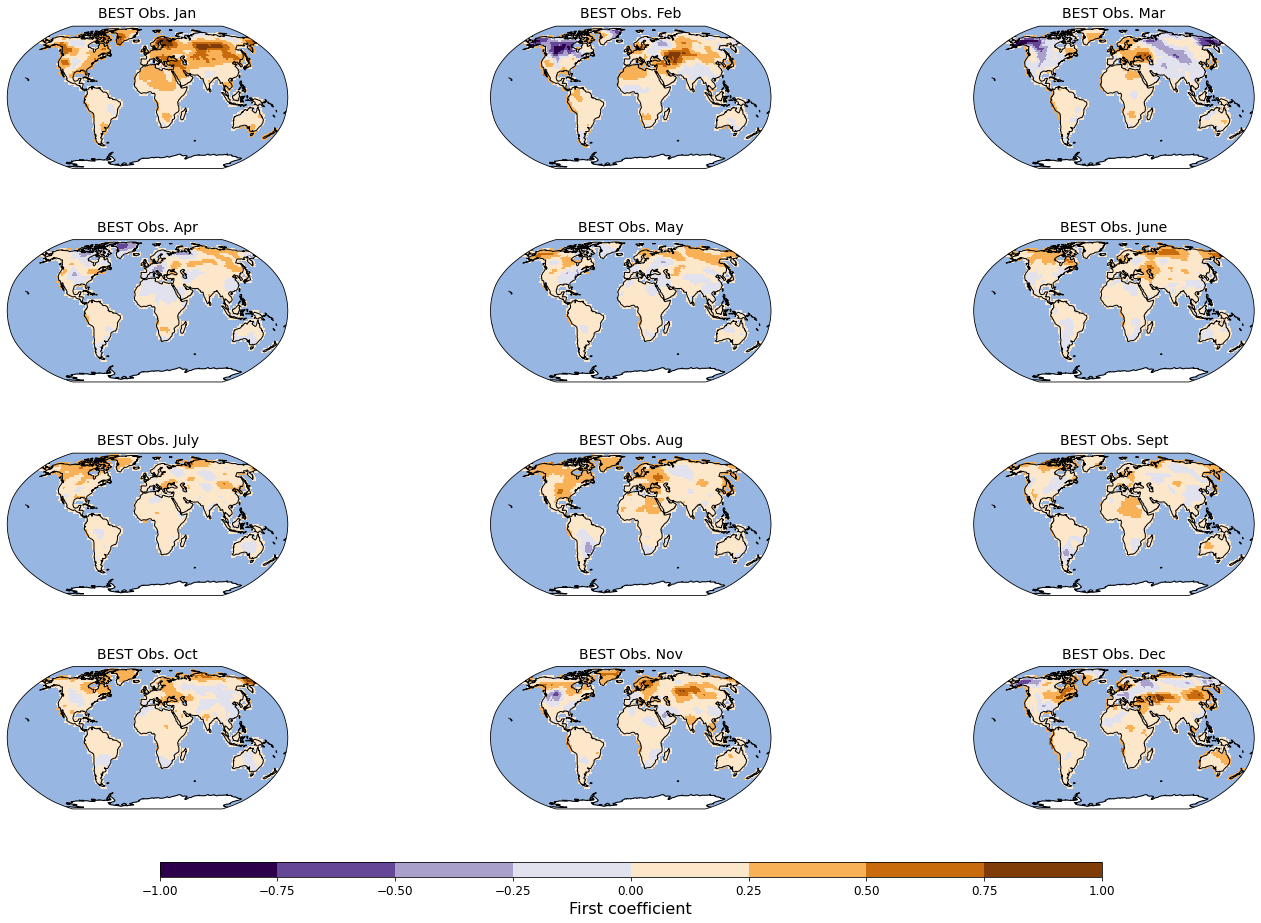

In [7]:
dir_in_data_mod = '/home/tristan/mesmer/output/'
coeffs_temp = joblib.load(dir_in_data_mod+'AR(1)_coeffs.pkl')
coeff_1 = coeffs_temp[1,:,:]

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.default':'it'})

months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

# white = np.array([248/256, 230/256, 200/256, 1])
# blue = np.array([30/256, 70/256, 130/256, 1])
# colors = np.vstack((white,blue))

# mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors, N=3)
# bounds = [ -1.5, 0.5, 1.5]
# norm = mpl.colors.BoundaryNorm(bounds, mymap.N)

bounds = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('PuOr_r')

n_col = 3
n_row = 4

fs_title=16

fig=plt.figure(figsize=(n_col*14, n_row * 18))

grid = plt.GridSpec(n_row*13+3, n_col*15+4, wspace=1, hspace=0) 

# create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for i in range(12):    
    if i%3==0:
        i_y=0
        ax = plt.subplot(grid[i+1:i+3,i_y:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
        
    else:
        ax = plt.subplot(grid[i-(i%3)+1:i-(i%3)+3,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
            
    i_y+=1
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)

    coeff = coeff_1[i,:]
    
    y_ma[idx_l] = coeff
    
    
#     ax.set_title('BEST Obs', months[i])
    ax.set_title('BEST Obs. %s' %months[i],y=1.02,fontsize=14)
    axcbar = plt.subplot(grid[i-(i%3)+3:i-(i%3)+4,5:25])
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=cmap, vmin=-1.0,vmax=1.0,transform=ccrs.PlateCarree(), norm=norm, rasterized=True)
    ax.add_feature(cfeature.OCEAN)
    plt.axis('off')
    ax.coastlines()
    
cbar=plt.colorbar(mesh_1, orientation='horizontal', fraction=0.25, aspect=65, ticks=([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]))
# cbar.ax.tick_params(labelsize=18), wspace=0.25, hspace=0, wspace=0.25, hspace=0, wspace=0.25, hspace=0, wspace=0.25, hspace=0

cbar.set_label('First coefficient',fontsize=16)

plt.show()

In [16]:
dir_in_data_mod = '/home/tristan/mesmer/output/'
train_res_trans = joblib.load(dir_in_data_mod+'train_residue_trans.pkl')
train_res_trans.shape

(112, 12, 3043)

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


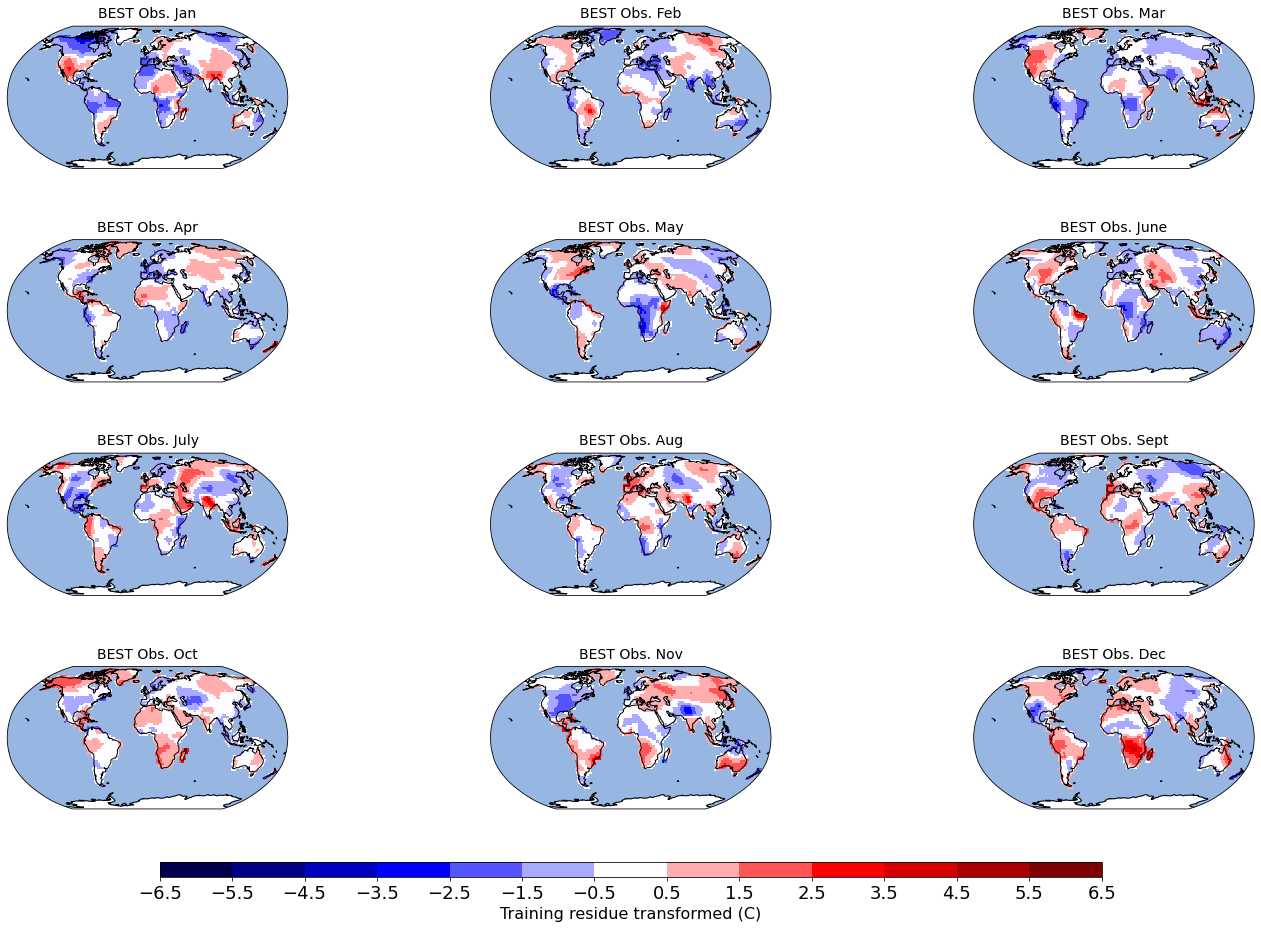

In [38]:
dir_in_data_mod = '/home/tristan/mesmer/output/'
coeffs_temp = joblib.load(dir_in_data_mod+'train_residue_trans.pkl')
coeff_1 = coeffs_temp[1,:,:]

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'})
plt.rcParams.update({'mathtext.default':'it'})

months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

# white = np.array([248/256, 230/256, 200/256, 1])
# blue = np.array([30/256, 70/256, 130/256, 1])
# colors = np.vstack((white,blue))

# mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors, N=3)
# bounds = [ -1.5, 0.5, 1.5]
# norm = mpl.colors.BoundaryNorm(bounds, mymap.N)

bounds = np.array([-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('seismic')

n_col = 3
n_row = 4

fs_title=16

fig=plt.figure(figsize=(n_col*14, n_row * 18))

grid = plt.GridSpec(n_row*13+3, n_col*15+4, wspace=1, hspace=0) 

# create a grid for the subplots #0.12

# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for i in range(12):    
    if i%3==0:
        i_y=0
        ax = plt.subplot(grid[i+1:i+3,i_y:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
        
    else:
        ax = plt.subplot(grid[i-(i%3)+1:i-(i%3)+3,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
            
    i_y+=1
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)

    coeff = coeff_1[i,:]
    
    y_ma[idx_l] = coeff
    
    
#     ax.set_title('BEST Obs', months[i])
    ax.set_title('BEST Obs. %s' %months[i],y=1.02,fontsize=14)
    axcbar = plt.subplot(grid[i-(i%3)+3:i-(i%3)+4,5:25])
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=cmap, vmin=-6.5,vmax=6.5,transform=ccrs.PlateCarree(), norm=norm, rasterized=True)
    ax.add_feature(cfeature.OCEAN)
    plt.axis('off')
    ax.coastlines()
    
cbar=plt.colorbar(mesh_1, orientation='horizontal', fraction=0.25, aspect=65, ticks=([-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]))
cbar.ax.tick_params(labelsize=18)

cbar.set_label('Training residue transformed (C)',fontsize=16)

plt.show()

# Create emulations

In [9]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

In [18]:
emu_res={}
nr_emus=500
buffer=10
nr_ts=112
dir_in_data_mod = '/home/tristan/mesmer/output/'
dir_out_data_mod = '/home/tristan/mesmer/output/'

##load calibration parameters for local variability module
df_llh_cv_all= joblib.load(dir_in_data_mod+'llh_cv_all.pkl')
coeffs_temp = joblib.load(dir_in_data_mod+'AR(1)_coeffs.pkl')
coeff_0 = coeffs_temp[0,:,:]
coeff_1 = coeffs_temp[1,:,:]
power_trans=joblib.load(dir_in_data_mod+'yeo_johnson_pt_fmin_log.pkl')

train_residue_trans=joblib.load(dir_in_data_mod+'train_residue_trans.pkl')

print('calculating covariance matrices')
innov_emu={}
for i_mon in tqdm(range(12)):
    L_sel=df_llh_cv_all[i_mon]['L_sel']
    ecov_res=np.cov(train_residue_trans[:,i_mon,:],rowvar=False)
    cov_res=phi[L_sel]*ecov_res
    cov_innov=np.zeros_like(cov_res)
    for i in tqdm(np.arange(idx_l.sum())):
        for j in np.arange(idx_l.sum()):
               cov_innov[i,j]=np.sqrt(1-coeff_1[i_mon,i]**2)*np.sqrt(1-coeff_1[i_mon,j]**2)*cov_res[i,j]
        cov_innov[np.isnan(cov_innov)]=0
        innov_emu[i_mon] = np.random.multivariate_normal(np.zeros(idx_l.sum()),cov_innov,size=[nr_emus,nr_ts+buffer],check_valid='warn')
    

print('innovations drawn')
emu_res[model]={}
innov_emu={}
for i_mon in tqdm(range(12)):
    innov_emu[i_mon] = np.random.multivariate_normal(np.zeros(idx_l.sum()),cov_innov[i_mon],size=[nr_emus,nr_ts+buffer],check_valid='warn')

start = dt.datetime.now()

for k in np.arange(nr_emus):
    emu_res[model][k]=np.zeros([nr_ts+buffer,12,idx_l.sum()])
    for t in np.arange(1,emu_res[model][k].shape[0]):
        for i_mon in range(12):

            if i_mon==0:
                emu_res[model][k][t,i_mon,:]=coeff_0[model][i_mon,:]+coeff_1[model][i_mon,:]*emu_res[model][k][t-1,11,:]+innov_emu[i_mon][k,t]

            else:
                emu_res[model][k][t,i_mon,:]=coeff_0[model][i_mon,:]+coeff_1[model][i_mon,:]*emu_res[model][k][t,i_mon-1,:]+innov_emu[i_mon][k,t]

    emu_res[model][k]=emu_res[model][k][buffer:,:,:]

    for i_mon in range(12):

        emu_res[model][k][:,i_mon,:]=power_inv_transform(power_trans[model][i_mon],emu_res[model][k][:,i_mon,:],y_all[model])

joblib.dump(emu_res,dir_out_data_mod+'%i_emulator_innovations_fmin_log.pkl'%(nr_emus))
time_taken = dt.datetime.now() - start

print('time taken to create %i emulations: '%(nr_emus*len(runs)), time_taken)

calculating covariance matrices


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/12 [00:00<?, ?it/s]

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3043 [00:00<?, ?it/s]

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: covariance is not positive-semidefinite.


KeyboardInterrupt: 

In [15]:
dir_out = '/home/tristan/mesmer/output/'

coeffs = joblib.load(dir_out+'AR(1)_coeffs.pkl')
coeffs[1].shape

(12, 3043)

In [1]:
emu_res={}
nr_emus=500
buffer=10
nr_ts=112
dir_in_data_mod = '/home/tristan/mesmer/output/'
dir_out_data_mod = '/home/tristan/mesmer/output/'

##load calibration parameters for local variability module
df_llh_cv_all= joblib.load(dir_in_data_mod+'llh_cv_all.pkl')
coeffs_temp = joblib.load(dir_in_data_mod+'AR(1)_coeffs.pkl')
coeff_0 = coeffs_temp[0,:,:]
coeff_1 = coeffs_temp[1,:,:]
power_trans=joblib.load(dir_in_data_mod+'yeo_johnson_pt_fmin_log.pkl')
train_residue_trans=joblib.load(dir_in_data_mod+'train_residue_trans.pkl')
innov_emu = joblib.load(dir_in_data_mod+'innov_emu.pkl')

start = dt.datetime.now()

for k in np.arange(nr_emus):
    emu_res[k]=np.zeros([nr_ts+buffer,12,idx_l.sum()])
    for t in np.arange(1,emu_res[k].shape[0]):
        for i_mon in range(12):

            if i_mon==0:
                emu_res[k][t,i_mon,:]=coeff_0[i_mon,:]+coeff_1[i_mon,:]*emu_res[k][t-1,11,:]+innov_emu[i_mon][k,t]

            else:
                emu_res[k][t,i_mon,:]=coeff_0[i_mon,:]+coeff_1[i_mon,:]*emu_res[k][t,i_mon-1,:]+innov_emu[i_mon][k,t]

    emu_res[k]=emu_res[k][buffer:,:,:]

    for i_mon in range(12):

        emu_res[k][:,i_mon,:]=power_inv_transform(power_trans[i_mon],emu_res[k][:,i_mon,:],y_all[model])

joblib.dump(emu_res,dir_out_data_mod+'%i_emulator_innovations_fmin_log.pkl'%(nr_emus))
time_taken = dt.datetime.now() - start

print('time taken to create %i emulations: '%(nr_emus*len(runs)), time_taken)

NameError: name 'joblib' is not defined

## try plot the lambdas


/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


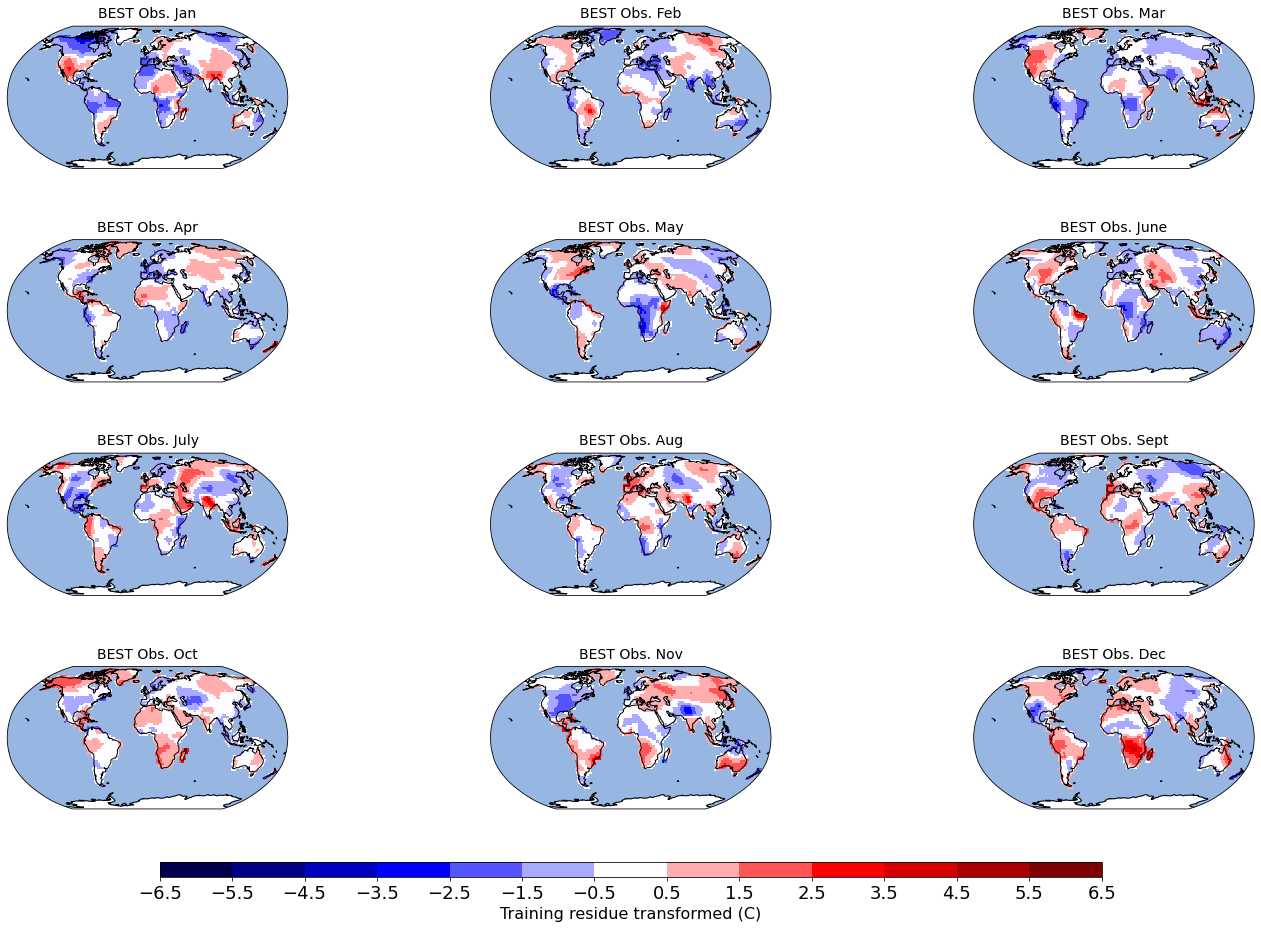

In [7]:
dir_in_data_mod = '/home/tristan/mesmer/output/'
coeffs_temp = joblib.load(dir_in_data_mod+'train_residue_trans.pkl')
coeff_1 = coeffs_temp[1,:,:]

months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

bounds = np.array([-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('seismic')

n_col = 3
n_row = 4

fs_title=16

fig=plt.figure(figsize=(n_col*14, n_row * 18))

grid = plt.GridSpec(n_row*13+3, n_col*15+4, wspace=1, hspace=0) 

# create a grid for the subplots #0.12

# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for i in range(12):    
    if i%3==0:
        i_y=0
        ax = plt.subplot(grid[i+1:i+3,i_y:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
        
    else:
        ax = plt.subplot(grid[i-(i%3)+1:i-(i%3)+3,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))
            
    i_y+=1
    
    y_ma = np.zeros(idx_l.shape)
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)

    coeff = coeff_1[i,:]
    
    y_ma[idx_l] = coeff
    
    
#     ax.set_title('BEST Obs', months[i])
    ax.set_title('BEST Obs. %s' %months[i],y=1.02,fontsize=14)
    axcbar = plt.subplot(grid[i-(i%3)+3:i-(i%3)+4,5:25])
    mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=cmap, vmin=-6.5,vmax=6.5,transform=ccrs.PlateCarree(), norm=norm, rasterized=True)
    ax.add_feature(cfeature.OCEAN)
    plt.axis('off')
    ax.coastlines()
    
cbar=plt.colorbar(mesh_1, orientation='horizontal', fraction=0.25, aspect=65, ticks=([-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]))
cbar.ax.tick_params(labelsize=18)

cbar.set_label('Training residue transformed (C)',fontsize=16)

plt.show()

In [20]:
dir_in_data_mod = '/home/tristan/mesmer/output/'
self = joblib.load(dir_in_data_mod+'yeo_johnson_pt_fmin_log.pkl')

self[i_mon-12]

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [33]:
for i_mon in range(12):
    coeffs = self[6].coeffs_

coeffs.shape    

(3043, 2)

In [34]:
model="BEST observations"
models=[model]

train_results_all={}
train_residue_all={}
y_all_mon={}
y_all={}

for model in models:

########## THIS SECTION CAN BE COMMNENTED OUT IF RUNNING DIRECTLY AFTER RUNNING THE PREVIOUS CELL ##############    
#Get directory to store outputs
    dir_in_data_mod = '/home/tristan/mesmer/data/'

    # prepare the inputs as array
    BEST_data = 'obs_data_25.nc'
    data_mask = 'interim_invariant_lsmask_regrid.nc'       
    
    df_obs = xr.open_mfdataset(dir_in_geo_dist+BEST_data).roll(lon=72) #open observation data
        
    #create the climatology values array
    y_ma = np.zeros((tot_months,idx_l.sum()))  #create emtpy array with correct shape
    for i in range(tot_months):
        y_ma[i] = df_obs.climatology.values[i%12,idx_l]    #fill climatology values in the array

    #create test data over date range - here, 127 years so 1910 incl. to 2022 incl. 
    ## 1344 is the number of months from 1910 until 2022
    data_test = np.nan_to_num(np.array([df_obs.temperature.values[720:2064,idx_l]]))
    data_test = data_test.reshape(tot_months,idx_l.sum())
    
    print(data_test.shape)
        
    #load in monthly temperature values by adding the temp anomolies to the climatology
    y_all_mon[model] = np.add(y_ma, data_test)     
    
    # now subtract the yearly average climatology so we are left with residuals
    y_all_mon[model] = y_all_mon[model] - np.reshape(np.tile(np.mean(df_obs.climatology.values[:,idx_l],axis=0),tot_months),(tot_months,idx_l.sum()))   

################## UNTIL HERE #########################             
        
    #calculate annual average temperature values- here we use nanmean to calculate the annual means for each gridpoint but skipping any Nan values
    y_all[model] = np.mean(y_all_mon[model].reshape(-1,12,idx_l.sum()),axis=1)
    print(y_all[model].shape)
    
    lambdas = get_yeo_johnson_lambdas(coeffs, y_all[model])

(1344, 3043)
(112, 3043)


In [35]:
dir_in_data_mod = '/home/tristan/mesmer/output/'

joblib.dump(lambdas,dir_in_data_mod+'lambdas-jul.pkl')

/home/tristan/miniconda3/envs/mesmer-env/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


['/home/tristan/mesmer/output/lambdas-jul.pkl']

In [101]:
##load lambdas for Jan and calculate the mean

lambdas_jan = joblib.load(dir_in_data_mod+'lambdas-jan.pkl')
lambdas_jan = np.mean(lambdas_jan, axis=0)

lambdas_jan.min()

1.0004287026942822

1.8343675436207827


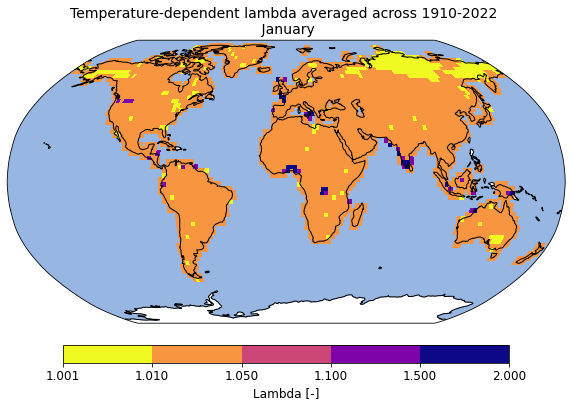

In [103]:
fig=plt.figure(figsize=(10,20))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))

y_ma = np.zeros(idx_l.shape)
y_ma = ma.masked_array(y_ma, mask=idx_l==False)
y_ma[idx_l]=lambdas_jan

print(y_ma.max())

bounds = np.array([1.001, 1.01, 1.05, 1.1, 1.5, 2.0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('plasma_r')

mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma, cmap=cmap,norm=norm, transform=ccrs.PlateCarree(),rasterized=True)

ax.set_title('Temperature-dependent lambda averaged across 1910-2022 \n January',fontsize=14)
ax.add_feature(cfeature.OCEAN)
cbar=plt.colorbar(mesh_1,ax=[ax],orientation='horizontal',ticks=([1.001, 1.01, 1.05, 1.1, 1.5, 2.0]),shrink=0.8,pad=0.02,aspect=25)
cbar.set_label('Lambda [-]')  
    
ax.coastlines()

plt.show()

1.980196223527592


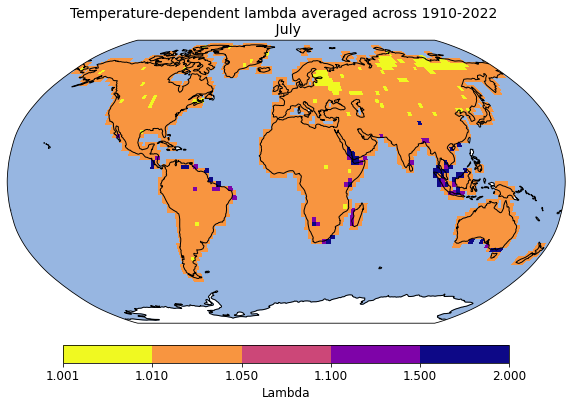

In [104]:
lambdas_jul = joblib.load(dir_in_data_mod+'lambdas-jul.pkl')
lambdas_jul = np.mean(lambdas_jul, axis=0)

fig=plt.figure(figsize=(10,20))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))

y_ma = np.zeros(idx_l.shape)
y_ma = ma.masked_array(y_ma, mask=idx_l==False)
y_ma[idx_l]=lambdas_jul

print(y_ma.max())

bounds = np.array([1.001, 1.01, 1.05, 1.1, 1.5, 2.0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
cmap = plt.cm.get_cmap('plasma_r')

mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma, cmap=cmap,norm=norm, transform=ccrs.PlateCarree(),rasterized=True)

ax.set_title('Temperature-dependent lambda averaged across 1910-2022 \n July',fontsize=14)
ax.add_feature(cfeature.OCEAN)
cbar=plt.colorbar(mesh_1,ax=[ax],orientation='horizontal',ticks=([1.001, 1.01, 1.05, 1.1, 1.5, 2.0]),shrink=0.8,pad=0.02,aspect=25)
cbar.set_label('Lambda')  
    
ax.coastlines()

plt.show()

## Plot both together